In [1]:
%load_ext autoreload
%autoreload 2
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path
import time
from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_exhaustive
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

In [2]:
images = Path('./Data/imgwithmask')
outputs = Path('./Data/spsgwithmask_outputs/')
!rm -rf $outputs
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
sfm_dir = outputs / 'sfm'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'

feature_conf = extract_features.confs['superpoint_aachen']
matcher_conf = match_features.confs['superglue']

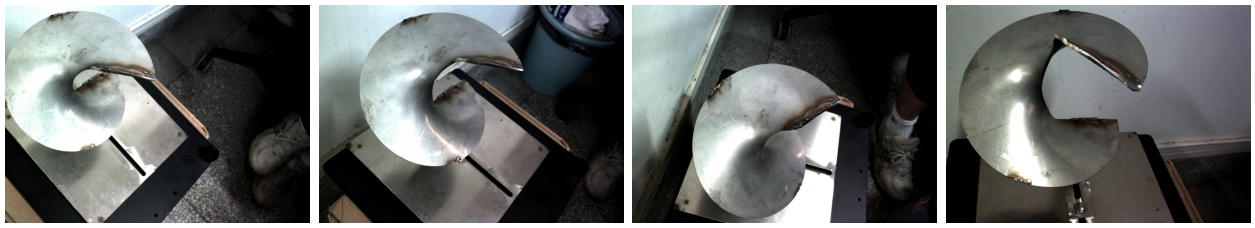

In [3]:
images1 = Path('./Data/rgb')
references1 = [p.relative_to(images1).as_posix() for p in (images1 / '').iterdir()]
plot_images([read_image(images1 / r) for r in references1[:4]], dpi=50)

33 mapping images


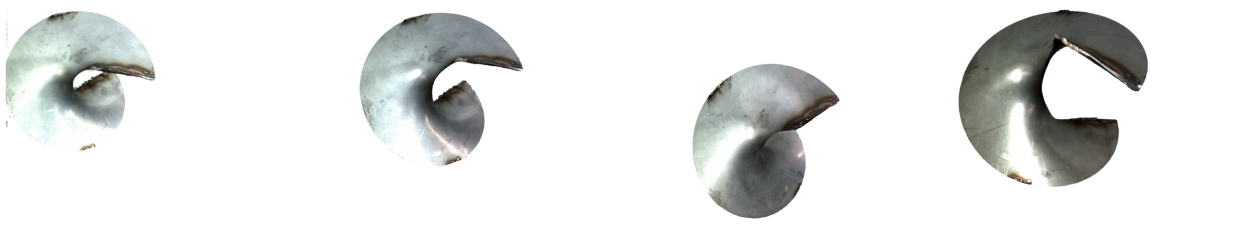

In [4]:
references = [p.relative_to(images).as_posix() for p in (images / '').iterdir()]
print(len(references), "mapping images")
plot_images([read_image(images / r) for r in references[:4]], dpi=50)

In [5]:
start = time.time()
extract_features.main(feature_conf, images, image_list=references, feature_path=features)
pairs_from_exhaustive.main(sfm_pairs, image_list=references)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches)

[2023/05/07 14:36:02 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}


Loaded SuperPoint model


  0%|          | 0/33 [00:00<?, ?it/s]

[2023/05/07 14:36:07 hloc INFO] Finished exporting features.
[2023/05/07 14:36:07 hloc INFO] Found 528 pairs.
[2023/05/07 14:36:07 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


  0%|          | 0/528 [00:00<?, ?it/s]

[2023/05/07 14:36:42 hloc INFO] Finished exporting matches.


PosixPath('/home/a410/Documents/Data/pic/baffle/spsgwithmask_outputs/matches.h5')

In [6]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, features, matches, image_list=references)
end = time.time()
print(end- start)
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, name="baffle")
fig.show()

[2023/05/07 14:36:42 hloc INFO] Creating an empty database...
[2023/05/07 14:36:42 hloc INFO] Importing images into the database...
[2023/05/07 14:36:46 hloc INFO] Importing features into the database...


  0%|          | 0/33 [00:00<?, ?it/s]

[2023/05/07 14:36:46 hloc INFO] Importing matches into the database...


  0%|          | 0/528 [00:00<?, ?it/s]

[2023/05/07 14:36:46 hloc INFO] Performing geometric verification of the matches...
[2023/05/07 14:36:50 hloc INFO] Running 3D reconstruction...
[2023/05/07 14:37:06 hloc INFO] Reconstructed 1 model(s).
[2023/05/07 14:37:06 hloc INFO] Largest model is #0 with 33 images.
[2023/05/07 14:37:06 hloc INFO] Reconstruction statistics:
Reconstruction:
	num_reg_images = 33
	num_cameras = 33
	num_points3D = 1423
	num_observations = 5131
	mean_track_length = 3.60576
	mean_observations_per_image = 155.485
	mean_reprojection_error = 1.32728
	num_input_images = 33


64.66718697547913


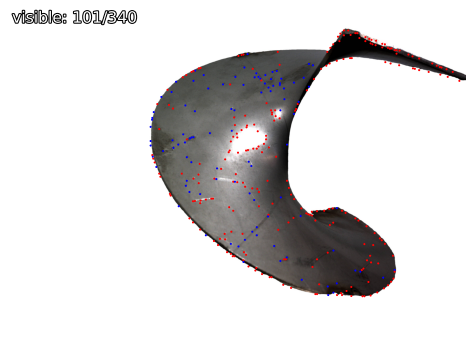

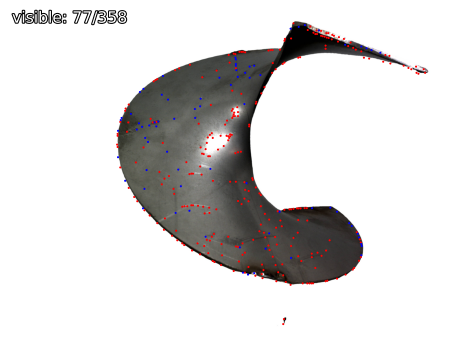

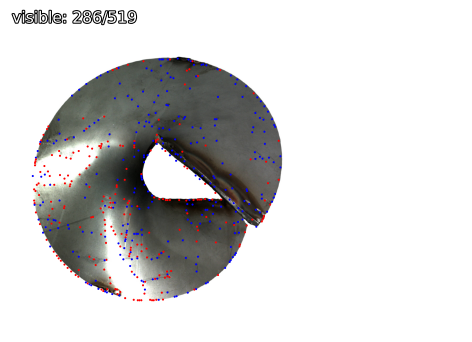

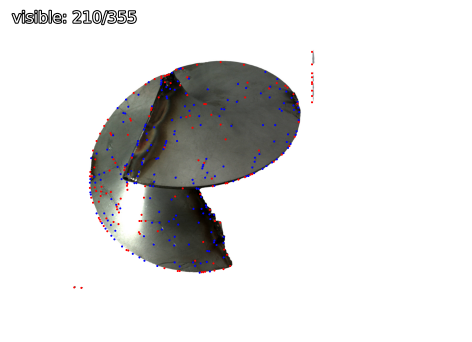

In [7]:
visualization.visualize_sfm_2d(model, images, color_by='visibility', n=4)

In [8]:
import numpy as np
num_key = 0
num_visible = 0
w = 3840
h = 2748
S = 0
ref_ids = [model.find_image_with_name(r).image_id for r in references if model.find_image_with_name(r)]
for ref_id in ref_ids:
    pic = model.images[ref_id]
    keypoints = np.array([p.xy for p in pic.points2D])
    visible = np.array([p.has_point3D() for p in pic.points2D])
    num_key =num_key + len(keypoints)
    num_visible = num_visible+ np.sum(visible!=0)
    visible_keys = np.array([keypoint for j,keypoint in enumerate(keypoints) if visible[j] == True])
    score = 0
    for L in range(1,6):
        w1 = int(w / (2**L))
        h1 = int(h / (2**L))
        gide = np.zeros((2**L+1,2**L+1))
        for visible_key in visible_keys:
            m = int(visible_key[0]//w1)
            n = int(visible_key[1]//h1)
            if gide[m,n] != 1:
                gide[m,n] = 1
        score = score + np.sum(gide) * (2**L)
    S = S + score
print(num_key/len(ref_ids))
print(num_visible/len(ref_ids))
print(S/len(ref_ids))

389.27272727272725
155.4848484848485
4417.69696969697


[2023/05/07 14:37:19 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}


Loaded SuperPoint model


  0%|          | 0/1 [00:00<?, ?it/s]

[2023/05/07 14:37:20 hloc INFO] Finished exporting features.
[2023/05/07 14:37:20 hloc INFO] Found 33 pairs.
[2023/05/07 14:37:20 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


  0%|          | 0/33 [00:00<?, ?it/s]

[2023/05/07 14:37:23 hloc INFO] Finished exporting matches.


PosixPath('/home/a410/Documents/Data/pic/baffle/spsgwithmask_outputs/matches.h5')

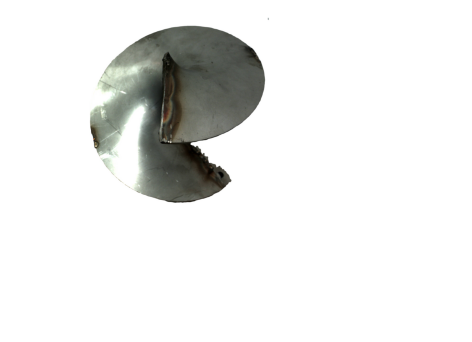

In [9]:
query = './Data/imgwithmask/00029.jpg'
plot_images([read_image(query)], dpi=75)

extract_features.main(feature_conf, images, image_list=[query], feature_path=features, overwrite=True)
pairs_from_exhaustive.main(loc_pairs, image_list=[query], ref_list=references)
match_features.main(matcher_conf, loc_pairs, features=features, matches=matches, overwrite=True)

found 198/521 inlier correspondences.


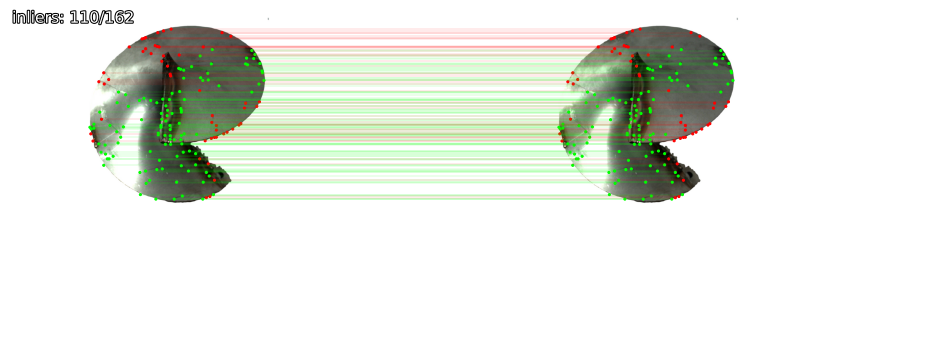

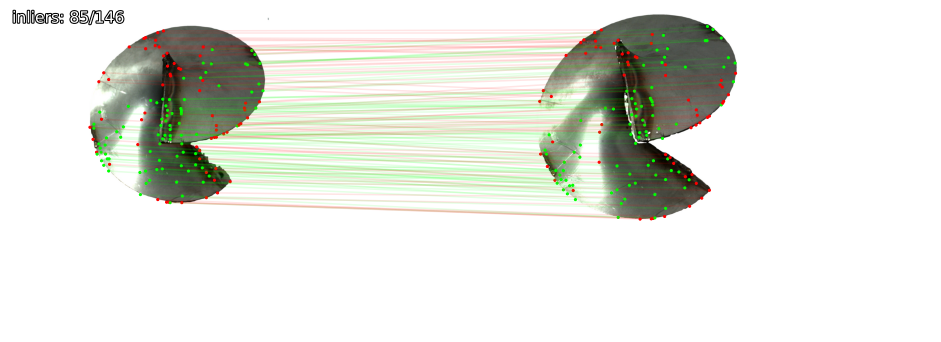

In [10]:
import pycolmap
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster

camera = pycolmap.infer_camera_from_image(images / query)
ref_ids = [model.find_image_with_name(r).image_id for r in references]

conf = {
    'estimation': {'ransac': {'max_error': 12}},
    'refinement': {'refine_focal_length': True, 'refine_extra_params': True},
}
localizer = QueryLocalizer(model, conf)
ret, log = pose_from_cluster(localizer, query, camera, ref_ids, features, matches)

print(f'found {ret["num_inliers"]}/{len(ret["inliers"])} inlier correspondences.')
visualization.visualize_loc_from_log(images, query, log, model)